#  Cat Boost

The aim of this notebook is to try out XG-boost on our optimization problem. There is also some ideas and concepts that will overlap with other machine learning models. Some novel ideas related to the preprocessing step is in this file, but SHOULD be moved to a dedicated pre-processing library to make the puipeline easier to work with.

*TODO: Create a preprocessing library*

### Import the needed libraries

In [1]:

# First we will extract the data, and save it to a csv.

# Machine Learning Model
import catboost as cb

# Data Processing Tools
import numpy as np
import pandas as pd
import seaborn as sns

# Data Display Tools
import matplotlib.pyplot as plt

# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import f_regression

import feature_generation as feat_gen
import data_processing as dat_proc
import data_pipeline as data_pipe

%matplotlib inline



### Extract data

In [2]:
train_a = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('C/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('C/X_test_estimated.parquet')

X_pred = X_test_estimated_a


### Preprocessing of data
Notice that we for now have a whole block dedicated to preprocessing, but should rather be its own module.

In [3]:
y = train_a.dropna()
X_train_estimated_a = X_train_estimated_a.drop("date_calc", axis = 1)

X = pd.concat([X_train_observed_a, X_train_estimated_a], axis = 0, ignore_index=True)
X, y= data_pipe.train_data_processing(X, y)

In [4]:
print(X[['double_derivative_absolute_humidity_2m:gm3_dd',
       'double_derivative_air_density_2m:kgm3_dd',
       'double_derivative_ceiling_height_agl:m_dd']].head(4))

# DO we get a day or the 
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, shuffle=True)

scaler = MinMaxScaler()

# Fit and transform the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

   double_derivative_absolute_humidity_2m:gm3_dd  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   

   double_derivative_air_density_2m:kgm3_dd  \
0                                  0.000000   
1                                  0.000000   
2                                 -0.000004   
3                                  0.000004   

   double_derivative_ceiling_height_agl:m_dd  
0                                  -0.076000  
1                                  -0.076889  
2                                  -0.078222  
3                                  -0.079556  


## AI Training: CatBoost


In [5]:

train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function="MAE", logging_level='Silent')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset, verbose=False)


pred = model.predict(X_test)
mae = (mean_absolute_error(y_test, pred))
r2 = r2_score(y_test, pred)
print("Testing performance")
print("Mean Abs: {:.2f}".format(mae))
print("R2: {:.2f}".format(r2))



In [ ]:
N = 100

feature_importance = model.get_feature_importance()

# Pair feature names with their importance scores
feature_importance_dict = dict(zip(model.feature_names_, feature_importance))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or use the top features
top_features = sorted_feature_importance[:N]  # Replace N with the number of top features you want
print(top_features)
labels = list(X.columns.values)

best_features = []
for feat in top_features:
    print(labels[int(feat[0])])
    best_features.append(labels[int(feat[0])])
print(best_features)

[('10', 21.36734616770574), ('36', 10.047221816276178), ('4', 7.691038955144018), ('11', 6.953574631016531), ('3', 3.9906273619339316), ('8', 3.319213102566903), ('181', 2.5307595599212123), ('174', 2.43216123838658), ('192', 2.3426277842823255), ('12', 2.0713393389025256), ('39', 2.050583045254787), ('184', 1.4310104371205685), ('169', 1.4141291705938464), ('80', 1.3651154842687006), ('148', 1.3634405653960882), ('53', 1.2412110226438784), ('81', 0.9985036562041831), ('159', 0.9778008316466944), ('200', 0.9440483640790077), ('223', 0.9172342860577332), ('55', 0.840533326087687), ('209', 0.828862209732965), ('54', 0.8100588359715467), ('100', 0.7998588512071804), ('42', 0.7995725787919045), ('160', 0.7505068093374829), ('173', 0.6852902075341306), ('217', 0.6550842141264243), ('101', 0.5968142689475047), ('125', 0.592088816311791), ('49', 0.5551918150560056), ('221', 0.5527951247208607), ('57', 0.5157104425021536), ('25', 0.48710458269719187), ('2', 0.45021044817311345), ('171', 0.4411

In [ ]:
X_pred = X_test_estimated_a
X_pred = data_pipe.pred_data_processing(X_pred)

X_val = scaler.transform(X_pred)
pred = model.predict(X_val)
pred_df = pd.DataFrame(pred)
pred_df.to_csv('C_Pred.csv')

c:\Users\isakasa\OneDrive - NTNU\Documents\UNI\TDT4173 Machine Learning\group-project\TDT4173-Machine-Learning-Solar-Energy-Production-Forecasting\data\feature_generation.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dder_df = dder_df.fillna(method="backfill", axis=None)


### Plotting
Adding a set of plotts to see how well the machine-learning model performs graphically.

TODO: We should probably plot the data-values that perform the worst.

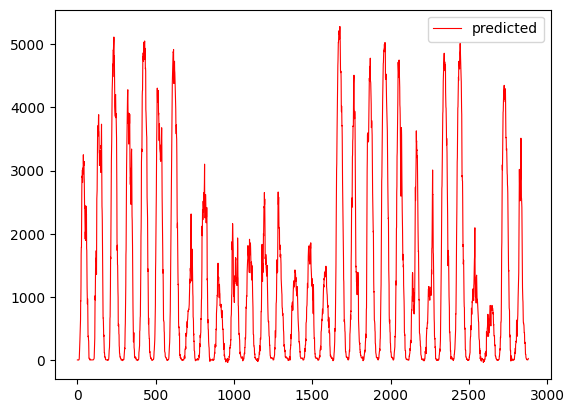

In [ ]:
# Create a set of predictors :/
# Predict when 0
# Predict when larger than 0
# Predict when max value occurs
# PRedict when 
 
x_ax = range(len(pred))

plt.plot(x_ax, pred[:], lw=0.8, color="red", label="predicted")

plt.legend()
plt.show()
